<a href="https://colab.research.google.com/github/rahulrajpr/AdvancedHyperParameterOptimisation/blob/SearchAlgorithms/GridSerachCV_CoarseFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach 

1. Coarse Tuning of the hyperparameter spaces
2. Fine Tuning of the hyper parameter spaces

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_breast_cancer

In [5]:
data = pd.DataFrame(data = load_breast_cancer().data, columns = load_breast_cancer().feature_names)

In [7]:
data['target'] = load_breast_cancer().target

In [9]:
data.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

In [10]:
X = data.drop('target', axis = 1)
y = data['target']

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state = 100)

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

In [14]:
gbc = GradientBoostingClassifier(random_state = 100)

In [ ]:
help(GradientBoostingClassifier)

### Coarse Tuning with GridSearch CV

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
params = {'n_estimators' : [10,20,50,100],
          'min_samples_split':[0.1,0.3,0.5],
          'max_depth' :[1,2,3,4,None]}

In [23]:
search = GridSearchCV(estimator = gbc,
                      param_grid = params,
                      scoring = 'roc_auc',
                      cv = 5,
                      verbose = 1,
                      n_jobs = -1,
                      return_train_score = True)

In [24]:
search.fit(X_train,y_train)
%time

Fitting 5 folds for each of 60 candidates, totalling 300 fits
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [25]:
search.best_params_

{'max_depth': 1, 'min_samples_split': 0.1, 'n_estimators': 100}

In [29]:
best_estimator = search.best_estimator_

In [32]:
pred_train = best_estimator.predict_proba(X_train)[:,1]
pred_test = best_estimator.predict_proba(X_test)[:,1]

In [34]:
from sklearn.metrics import roc_auc_score

In [37]:
print('train roc_auc score : ',roc_auc_score(y_train,pred_train))
print('test roc_auc score : ',roc_auc_score(y_test,pred_test))

train roc_auc score :  0.9981351981351982
test roc_auc score :  0.9948849104859334


In [57]:
sel_cols = ['rank_test_score','param_n_estimators','param_min_samples_split','param_max_depth','mean_test_score','std_test_score']

In [62]:
results = pd.DataFrame(search.cv_results_).sort_values('rank_test_score')[sel_cols].set_index('rank_test_score')

In [63]:
results.head(10)

,param_n_estimators,param_min_samples_split,param_max_depth,mean_test_score,std_test_score
rank_test_score,,,,,
1,100,0.1,1,0.991616,0.004332
1,100,0.3,1,0.991616,0.004332
1,100,0.5,1,0.991616,0.004332
4,50,0.1,1,0.990962,0.005705
4,50,0.3,1,0.990962,0.005705
4,50,0.5,1,0.990962,0.005705
7,100,0.5,4,0.990674,0.003828
8,100,0.5,2,0.990655,0.003231
9,100,0.3,2,0.990645,0.003503


In [120]:
def plot_results(result,parameter):
  avg = result.groupby(parameter)['mean_test_score'].mean()
  std = result.groupby(parameter)['mean_test_score'].std()
  plt.figure(figsize = [8,5])
  avg.plot(yerr = [std,std], subplots =True)
  plt.show()

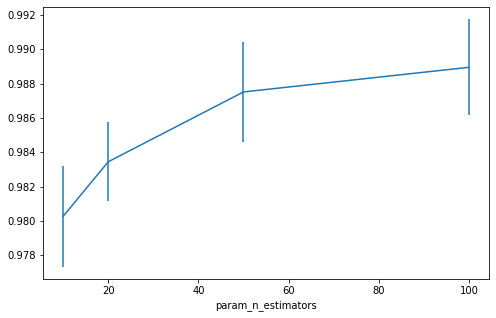

In [121]:
plot_results(results,'param_n_estimators')

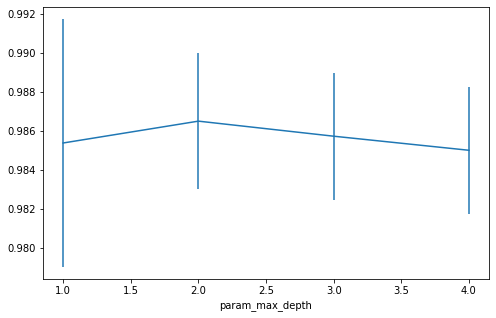

In [122]:
plot_results(results,'param_max_depth')

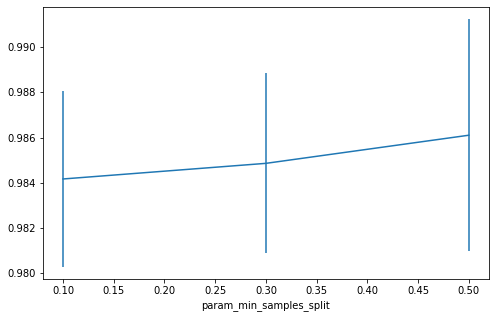

In [123]:
plot_results(results,'param_min_samples_split')

From the above plot, it is evident that, 

1. n_estimators seems good between 60 and 100
2. max_depth seems good between 2 and 3
3. min_sample_splis does not have an impact in the model

### Fine Tuning using Grid Search CV

In [105]:
params = {'n_estimators':[60,80,100,120],
          'max_depth' : [2,3],
          'loss' : ['deviance','exponential']}

In [106]:
gbc = GradientBoostingClassifier(random_state = 100)

In [107]:
search_fine = GridSearchCV(estimator = gbc,
                      param_grid = params,
                      scoring = 'roc_auc',
                      cv = 5,
                      verbose = 1,
                      n_jobs = -1,
                      return_train_score = True)

In [109]:
search_fine.fit(X_train,y_train)
%time

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [110]:
search_fine.best_params_

{'loss': 'deviance', 'max_depth': 2, 'n_estimators': 120}

In [111]:
best_estimator_fine = search_fine.best_estimator_

In [112]:
pred_train = best_estimator_fine.predict_proba(X_train)[:,1]
pred_test = best_estimator_fine.predict_proba(X_test)[:,1]

In [113]:
print('train roc_auc score : ',roc_auc_score(y_train,pred_train))
print('test roc_auc score : ',roc_auc_score(y_test,pred_test))

train roc_auc score :  1.0
test roc_auc score :  0.9931798806479114


In [115]:
sel_cols = ['rank_test_score','param_n_estimators','param_loss','param_max_depth','mean_test_score','std_test_score']

In [116]:
results_fine = pd.DataFrame(search_fine.cv_results_).sort_values('rank_test_score')[sel_cols].set_index('rank_test_score')

In [118]:
results_fine.head(10)

,param_n_estimators,param_loss,param_max_depth,mean_test_score,std_test_score
rank_test_score,,,,,
1,120,deviance,2,0.990244,0.004007
2,100,deviance,2,0.990104,0.003633
3,80,deviance,2,0.989810,0.004463
4,120,exponential,2,0.989694,0.004542
5,100,exponential,2,0.989539,0.004888
6,120,deviance,3,0.989534,0.005425
7,80,exponential,2,0.989119,0.004944
8,60,deviance,2,0.988629,0.005795
9,60,exponential,2,0.988194,0.006947


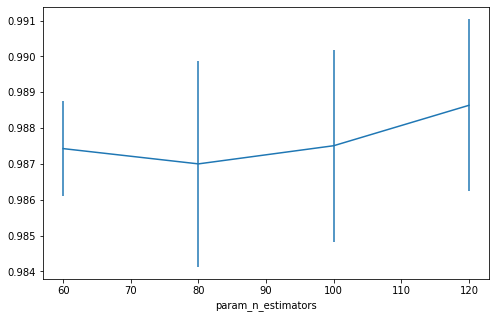

In [124]:
plot_results(results_fine,'param_n_estimators')

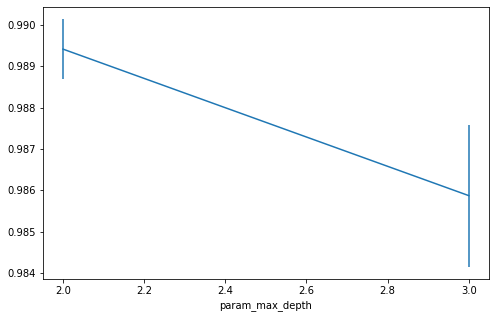

In [126]:
plot_results(results_fine,'param_max_depth')

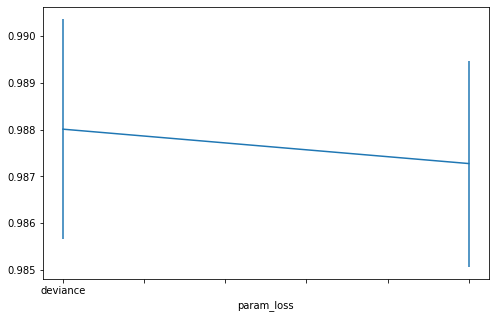

In [125]:
plot_results(results_fine,'param_loss')

In [127]:
search_fine.best_params_

{'loss': 'deviance', 'max_depth': 2, 'n_estimators': 120}